<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Generative adversarial networks


В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
!pip install celluloid -qq

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения

In [ ]:
DATA_DIR = 'images/'

In [ ]:
%%capture
!mkdir -p {DATA_DIR}
!cp /content/drive/MyDrive/edu/faces_dataset_small.zip .
!unzip faces_dataset_small.zip -d {DATA_DIR}
!rm -rf images/__MACOSX

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def get_dataloader(image_size, batch_size, is_test=False):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
  ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
  dl = DataLoader(ds, batch_size, shuffle=not is_test, num_workers=2, pin_memory=True)
  return dl

In [ ]:
image_size = 64
batch_size = 32
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_dl = get_dataloader(image_size, batch_size)

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

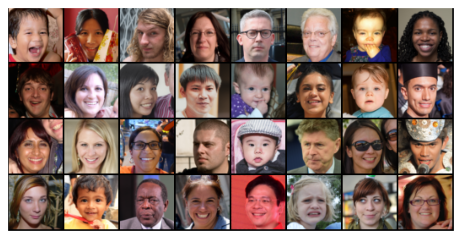

In [ ]:
show_batch(train_dl)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
# на основе семинара

discriminator = nn.Sequential(
    # in: 3 x image_size x image_size

    nn.Conv2d(3, image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(image_size, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x image_size x image_size
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0001

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
from IPython.display import clear_output
import os
try:
  from celluloid import Camera
except:
  pass

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1, make_animation=True):
  # build optimizers and train your GAN
  model["discriminator"].train()
  model["generator"].train()
  torch.cuda.empty_cache()
  
  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []
  
  # Create optimizers
  optimizer = {
      "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                        lr=lr, betas=(0.5, 0.999)),
      "generator": torch.optim.Adam(model["generator"].parameters(),
                                    lr=lr, betas=(0.5, 0.999))
  }
  fig, ax = plt.subplots(figsize=(8, 8))
  
  if make_animation:
    camera = Camera(fig)
  
  for epoch in range(epochs):
      loss_d_per_epoch = []
      loss_g_per_epoch = []
      real_score_per_epoch = []
      fake_score_per_epoch = []
      for real_images, _ in tqdm(train_dl):
          # Train discriminator
          # Clear discriminator gradients
          optimizer["discriminator"].zero_grad()

          # Pass real images through discriminator
          real_preds = model["discriminator"](real_images)
          real_targets = torch.ones(real_images.size(0), 1, device=device)
          real_loss = criterion["discriminator"](real_preds, real_targets)
          cur_real_score = torch.mean(real_preds).item()
          
          # Generate fake images
          latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
          fake_images = model["generator"](latent)

          # Pass fake images through discriminator
          fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
          fake_preds = model["discriminator"](fake_images)
          fake_loss = criterion["discriminator"](fake_preds, fake_targets)
          cur_fake_score = torch.mean(fake_preds).item()

          real_score_per_epoch.append(cur_real_score)
          fake_score_per_epoch.append(cur_fake_score)

          # Update discriminator weights
          loss_d = real_loss + fake_loss
          loss_d.backward()
          optimizer["discriminator"].step()
          loss_d_per_epoch.append(loss_d.item())


          # Train generator
          # Clear generator gradients
          optimizer["generator"].zero_grad()
          
          # Generate fake images
          latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
          fake_images = model["generator"](latent)
          
          # Try to fool the discriminator
          preds = model["discriminator"](fake_images)
          targets = torch.ones(batch_size, 1, device=device)
          loss_g = criterion["generator"](preds, targets)
          
          # Update generator weights
          loss_g.backward()
          optimizer["generator"].step()
          loss_g_per_epoch.append(loss_g.item())
          
      # Record losses & scores
      losses_g.append(np.mean(loss_g_per_epoch))
      losses_d.append(np.mean(loss_d_per_epoch))
      real_scores.append(np.mean(real_score_per_epoch))
      fake_scores.append(np.mean(fake_score_per_epoch))
      
      clear_output(wait=True)

      # Log losses & scores (last batch)
      print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
          epoch+1, epochs, 
          losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
      
      
      fake_images = model["generator"](fixed_latent)
      nmax=4
      images = fake_images.detach().cpu()
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
      plt.show();
      if make_animation:
        camera.snap()
      
      # Save generated images
      if epoch == epochs - 1:
        save_samples(epoch+start_idx, fixed_latent, show=False)

  if make_animation:
    animation = camera.animate()
    animation.save('animation.mp4')  
  
  return losses_g, losses_d, real_scores, fake_scores

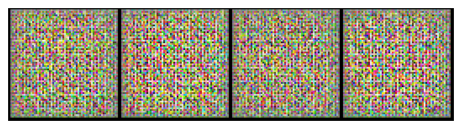

In [ ]:
fake_images = model["generator"](fixed_latent)
show_images(fake_images.detach().cpu(), 4)

In [ ]:
epochs = 40
history = fit(model, criterion, epochs, lr)

Epoch [40/40], loss_g: 4.6370, loss_d: 0.1461, real_score: 0.9372, fake_score: 0.0606
Saving generated-images-0040.png


итак, полученное видео в итоге залито на ютуб, можно посмотреть, как там оно тренировалось
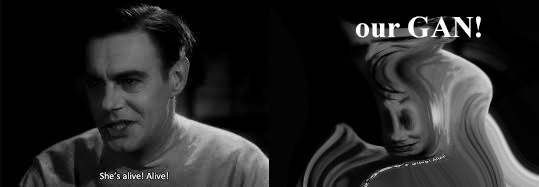

In [1]:
%%HTML
<iframe width="480" height="382" src="https://www.youtube.com/embed/3qFrOVPuSRU" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

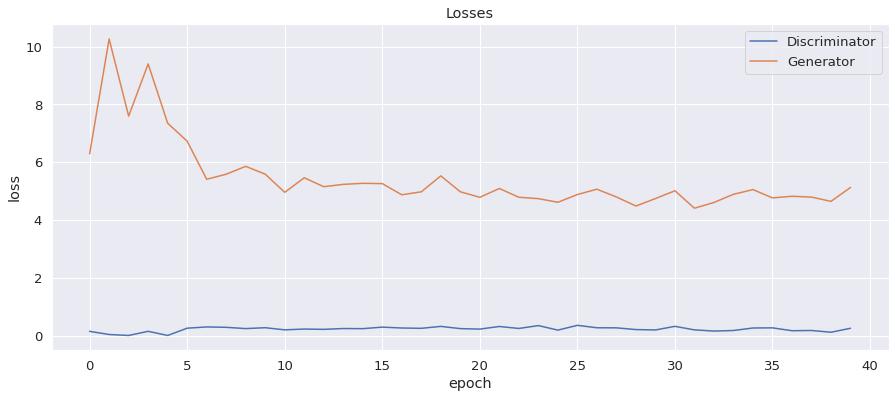

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

в принципе логично, задача дискриминатора на бинарным лоссом она несколько проще сходится, логично получить низкий лосс, видно что можно было тренировать дольше чем 40 эпох (идеально будет когда у дискриминатора лосс будет повышаться). в случае дискриминатора вначале идет рандомный шум и видно до 5 эпохи блуждания, но потом по мере генерации картинок более высокого качества, лосс начинает падать 

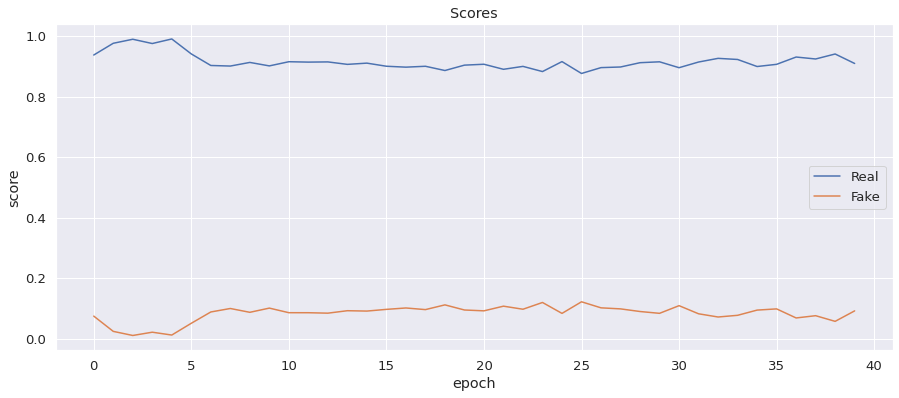

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

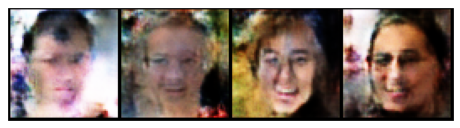

In [ ]:
with torch.no_grad():
  n_images = 4
  fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
  fake_images = model["generator"](fixed_latent)
  show_images(fake_images.detach().cpu(), 4)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from sklearn.metrics import *
import glob2 as glob
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_predict

In [ ]:
!gdown https://drive.google.com/uc?id=1xWuWDBRX_AffMQymquGnyybPbJXqW6V_
!gdown https://drive.google.com/uc?id=1--hw6lYVkgJKjlC8VZegJNww15rNxbxG

Downloading...
From: https://drive.google.com/uc?id=1xWuWDBRX_AffMQymquGnyybPbJXqW6V_
To: /content/discriminator.pt
11.1MB [00:00, 42.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--hw6lYVkgJKjlC8VZegJNww15rNxbxG
To: /content/generator.pt
15.2MB [00:00, 57.7MB/s]


In [ ]:
if os.path.exists("generator.pt"):
  model["generator"].load_state_dict(torch.load("generator.pt"))
if os.path.exists("discriminator.pt"):
  model["discriminator"].load_state_dict(torch.load("discriminator.pt"))

In [ ]:
import copy
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

может не самая удачная идея, но давайте использовать наш же дискриминатор в виде feature_extractor

In [ ]:
feature_extractor = copy.deepcopy(model["discriminator"])

In [ ]:
# Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
feature_extractor[12] = nn.Conv2d(512, 100, kernel_size=(4, 4), stride=(1, 1), bias=False).to(device)
# sigmoid
feature_extractor[14] = Identity()

In [ ]:
feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [ ]:
GENERATE_DATA = False

In [ ]:
%%capture

import uuid

def generate_samples(len_samples, dest_dir):
    while len_samples!=0:
      latent_tensors = torch.randn(64, latent_size, 1, 1, device=device)
      fake_images = generator(latent_tensors)
      fake_fname_template = '{0}.png'
      for index in range(fake_images.shape[0]):
        if len_samples==0:break
        fake_fname = fake_fname_template.format(str(uuid.uuid4()))
        fake_image = fake_images[index]
        save_image(denorm(fake_image), os.path.join(dest_dir, fake_fname))
        len_samples-=1

if GENERATE_DATA:
  !mkdir -p dataset_faces/fake
  generate_samples(len(train_dl.dl.dataset), dest_dir="dataset_faces/fake")
  !mkdir -p dataset_faces/real

  dest_dir = "dataset_faces/real" 
  for i in range(len(train_dl.dl.dataset)):
    real_image = train_dl.dl.dataset[i][0]
    save_image(denorm(real_image), os.path.join(dest_dir, '{0}.png'.format(str(uuid.uuid4()))))
else:
  !gdown https://drive.google.com/uc?id=1-39Uf4wWeVh8cP1gO7t1Fhgg-YN_X7Oa
  !unzip dataset_faces.zip

In [ ]:
img_count = len(glob.glob("dataset_faces/*/*.png"))
img_count

6286

In [ ]:
X = np.zeros((img_count, 100))
y = np.zeros((img_count))

In [ ]:
def get_dataloader(image_size, batch_size, data_dir):
  ds = ImageFolder(data_dir, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
  dl = DataLoader(ds, batch_size, shuffle=False)
  return dl

In [ ]:
# jupyter "bug"
!rm -rf dataset_faces/.ipynb_checkpoints

In [ ]:
image_dl = get_dataloader(image_size, batch_size=1, data_dir="dataset_faces")

In [ ]:
image_dl.dataset.class_to_idx

{'fake': 0, 'real': 1}

In [ ]:
i = 0
for batch_x, batch_labels in image_dl:
  X[i:i+len(batch_x)] = feature_extractor(batch_x.to(device)).detach().cpu().numpy()
  y[i:i+len(batch_x)] = batch_labels.detach().cpu().numpy()
  i+=len(batch_x)

In [ ]:
loo = LeaveOneOut()
loo.get_n_splits(X)

6286

In [ ]:
actual = []
predicted = []

for train_index, test_index in tqdm(loo.split(X), total=loo.get_n_splits(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    classifier = KNeighborsClassifier(n_neighbors=1)  
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    actual.append(y_test[0])
    predicted.append(y_pred[0])

In [ ]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

         0.0       0.74      0.99      0.85      3143
         1.0       0.99      0.65      0.78      3143

    accuracy                           0.82      6286
   macro avg       0.86      0.82      0.81      6286
weighted avg       0.86      0.82      0.81      6286



Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

> ну результат по классификации хороший, а значит плохой) мы хотели бы получать картинки, плохо отличающиеся от реальных, а следовательно ожидали бы accuracy в районе рандома ~50% . с другой стороны по первому ближайшему соседу классифицировать, вероятно находятся пара точек одного класса в одной плоскости в большинстве случаев близко, что говорит о несовршенстве нашего GAN (для генерации мы "батчами" брали новый latent vector)

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
%%capture
!pip install umap-learn
!pip install umap-learn[plot]

/usr/local/lib/python3.7/dist-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


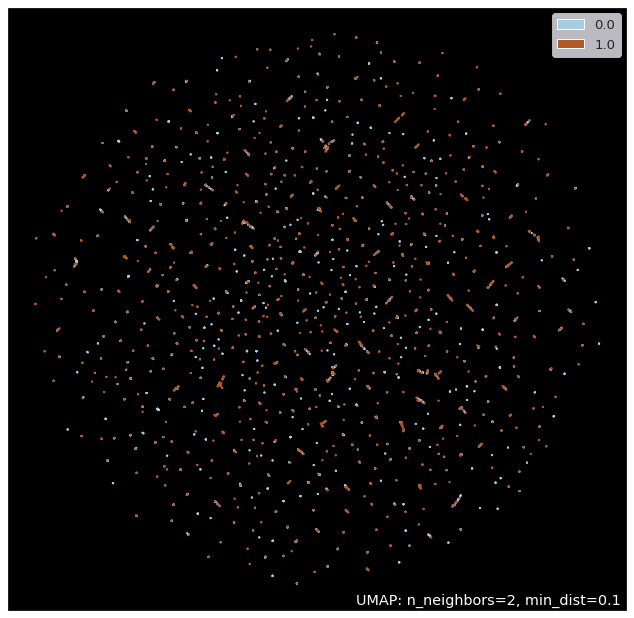

In [ ]:
import umap.plot

mapper = umap.UMAP(n_neighbors=2).fit(X)
umap.plot.points(mapper, labels=y, color_key_cmap='Paired', background='black')

In [ ]:
from sklearn.manifold import TSNE

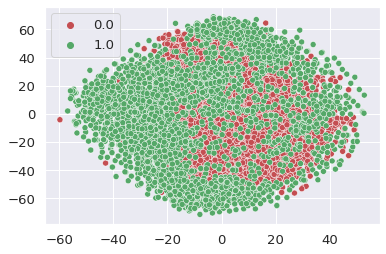

In [ ]:
X_2d = TSNE(n_components=2).fit_transform(X)
colors = {0: 'r', 1: 'g'}
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y, palette=colors)

Прокомментируйте получившийся результат:

В целом результат не так уж и плох, по TSNE и UMAP мы видим что классы как миним линейно не разделимы, уже хорошо. по UMAP хорошо видно, что фейковые картинки лежат близко и не выделяются в отдельный кластер